# Building the 1D CNN

### Import the relevant packages

In [1]:
%matplotlib inline
import expressyeaself.construct_neural_net as construct
import expressyeaself.encode_sequences as encode
import expressyeaself.organize_data as organize 
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess
import sys
from tqdm import tqdm

import tensorflow as tf
tf.get_variable('test_bool', 1, tf.bool)
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd() + '/'
CHECKPOINTS_DIR = ROOT_DIR + 'expressyeaself/models/1dcnn/checkpoints/'

### Define the input data

#### Using the full data set

In [29]:
sample_filename = ('20190608104912821947_sequences_inserted_into_Abf1TATA_scaffold_'
                   'padded_at_back_with_exp_levels.txt.gz')
sample_filename

'20190608104912821947_sequences_inserted_into_Abf1TATA_scaffold_padded_at_back_with_exp_levels.txt.gz'

#### Using a smaller sample set

In [25]:
sample_filename = '10000_from_' + sample_filename 

#### Define the absolute path

In [26]:
sample_path = ROOT_DIR + 'example/processed_data/' + sample_filename

### Encode sequences

In [27]:
# Seems to give slightly better accuracy when expression level values aren't scaled.
scale_els = False

In [28]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=scale_els, model_type='1DCNN')
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)


AssertionError: Input file does not exist.

### Reshape expression levels

In [4]:
y_scaled = y_scaled.reshape((len(y_scaled), 1))
# scaler = MinMaxScaler()
# scaler.fit(y_scaled)
# y_scaled = scaler.transform(y_scaled)

### Perform a train-test split

In [5]:
test_size = 0.25

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

### Build the model architecture

In [17]:
scores = []
batch_size = 250

In [18]:
tb = TensorBoard(log_dir='./logs', histogram_freq=3, batch_size=batch_size, write_graph=True, write_grads=True, 
                 write_images=True)
checkpointer = ModelCheckpoint(monitor='val_acc', filepath=(CHECKPOINTS_DIR + '1dcnn_onehot.hdf5'), verbose=1, save_best_only=True)



W0609 23:01:45.300096 4590572992 callbacks.py:1466] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0609 23:01:45.301973 4590572992 callbacks.py:1469] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


In [19]:
filters = 32
kernel_size = 5
strides = 2
epochs = 20
dropout = 0.5

model = Sequential()
model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(max_sequence_len, 5)))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(3, strides))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 288, 32)           832       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 284, 32)           5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 141, 32)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 137, 32)           5152      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 133, 32)           5152      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

Train on 75000 samples, validate on 25000 samples
Epoch 1/20
75000/75000 [==============================] - 64s 847us/sample - loss: 55.8562 - acc: 0.0172 - val_loss: 55.6318 - val_acc: 0.0192
Epoch 2/20
75000/75000 [==============================] - 76s 1ms/sample - loss: 55.7685 - acc: 0.0173 - val_loss: 55.6318 - val_acc: 0.0192
Epoch 3/20
75000/75000 [==============================] - 66s 883us/sample - loss: 55.7674 - acc: 0.0173 - val_loss: 55.6318 - val_acc: 0.0192
Epoch 4/20
75000/75000 [==============================] - 70s 931us/sample - loss: 55.7668 - acc: 0.0173 - val_loss: 55.6318 - val_acc: 0.0192
Epoch 5/20
75000/75000 [==============================] - 70s 933us/sample - loss: 55.7658 - acc: 0.0173 - val_loss: 55.6318 - val_acc: 0.0192
Epoch 6/20
75000/75000 [==============================] - 70s 931us/sample - loss: 55.7662 - acc: 0.0173 - val_loss: 55.6318 - val_acc: 0.0192
Epoch 7/20
75000/75000 [==============================] - 67s 889us/sample - loss: 55.7658 - a

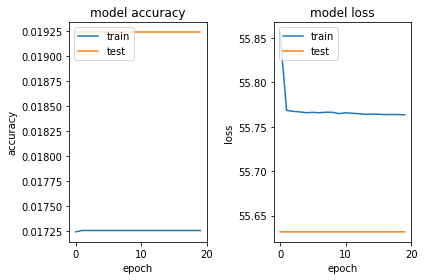

In [20]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test))#, callbacks=[checkpointer])

# evaluate the model
score = max(history.history['val_acc'])
scores.append(score)
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

In [ ]:
scores